# DataLoader

For showing and testing DataLoader.py, as well as creating and saving the dataframes containing the training data.

In [1]:
import mne, mne_bids, HelperFunctions, warnings
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from mne_bids import (BIDSPath, read_raw_bids)
from autoreject import AutoReject


def load_raw(data_path, task, preprocessing, subject_id):
    """
    Loads a single subject from the ERP Core data, applies filtering 
    and ICA, downsamples, and returns a mne.Raw object.
    """
    with HelperFunctions.suppress_stdout(), warnings.catch_warnings():
        # ignore warnings, as ERP Core is not quite in BIDS format
        warnings.simplefilter("ignore")
        bids_root = data_path+"/"+"ERP_CORE_BIDS_Raw_Files"
        bids_path = BIDSPath(subject=subject_id, task=task,
                             session=task, datatype='eeg', 
                             suffix='eeg', root=bids_root)
        raw = read_raw_bids(bids_path)
        raw.load_data()
        HelperFunctions.read_annotations_core(bids_path,raw)
        raw.set_channel_types({'HEOG_left': 'eog', 'HEOG_right': 'eog', 'VEOG_lower': 'eog'})
        raw.set_montage('standard_1020',match_case=False)
        if preprocessing == "medium":
            raw.filter(0.5,40)
        if preprocessing == "heavy":
            raw.filter(0.5,40)
            ica, badComps = HelperFunctions.load_precomputed_ica(bids_root, subject_id,task)
            HelperFunctions.add_ica_info(raw,ica)
            ica.apply(raw)
        raw = raw.resample(250)
    return raw

def epoch_raw(raw, task, preprocessing, reject_incorrect_responses=True):
    """
    Takes a mne.Raw object, loads the correct events, 
    and returns a mne.Epoch object.
    """
    with HelperFunctions.suppress_stdout():
        # get correct tmin, tmax, and event mapping per task
        custom_mapping, tmin, tmax = get_task_specifics(task)
        
        # shift annotations by lcd monitor delay
        if task != "MMN":
            raw.annotations.onset = raw.annotations.onset+.026
        
        # load events
        (events_from_annot, event_dict) = mne.events_from_annotations(raw, event_id=custom_mapping)
        
        if reject_incorrect_responses == True and task in ["N170", "N400", "N2pc", "P3"]:
        # only include events where response is in time and correct
            events_0, lag_0 = mne.event.define_target_events(events_from_annot, 0, 201, raw.info['sfreq'], 0, 0.8, 0, 999)
            events_1, lag_1 = mne.event.define_target_events(events_from_annot, 1, 201, raw.info['sfreq'], 0, 0.8, 1, 999)
            events_from_annot = np.concatenate((events_0, events_1), axis=0)
            # sort event array by timepoints to get rid of warning
            events_from_annot = events_from_annot[events_from_annot[:, 0].argsort()]
            # drop responses
            event_dict.pop('response:201')
            event_dict.pop('response:202')           

        # epoch with no constant detrend to remove dc offset, pick electrodes
        epoch = mne.Epochs(raw, events_from_annot, event_dict,
                           tmin=tmin,tmax=tmax, preload=True,
                           reject_by_annotation=True, baseline=None, 
                           picks=['F3','F7','FC3','C3','C5','P3','P7','P9',
                                  'PO7','PO3','O1','Oz','Pz','CPz','Fz','F4',
                                  'F8','FC4', 'FCz','Cz','C4','C6','P4','P8',
                                  'P10','PO8','PO4','O2'], detrend=0)
        
        # apply autoreject for heavy preprocessing to remove artefacts
        if preprocessing == "heavy":
            ar = AutoReject()
            epoch = ar.fit_transform(epoch) 
    return epoch

def get_task_specifics(task, reject_incorrect_responses=True):
    """
    Returns mapping, tmin, tmax, specific to the task.
    """
    tmin = -0.2
    tmax = 0.8
    # mapping is always: 
    # ERP component not expected -> 0
    # ERP component expected -> 1
    # or left -> 0, right -> 1
    if task == "N170":
        # Cars: 0, Faces: 1
        custom_mapping = dict(("stimulus:"+str(i), 1) for i in range(0,41))
        custom_mapping.update(dict(("stimulus:"+str(i), 0) for i in range(41,81)))
    elif task == "N400":
        # unrelated word: 1, Related word: 0
        custom_mapping = {'stimulus:221': 1, 'stimulus:222': 1, 
                          'stimulus:211': 0, 'stimulus:212': 0} 
    elif task == "P3":
        # target=stimulus (rare): 1, target!=stimulus (frequent): 0
        custom_mapping = {'stimulus:11': 1, 'stimulus:12': 0, 'stimulus:13': 0, 'stimulus:14': 0, 'stimulus:15': 0, 
                          'stimulus:21': 0, 'stimulus:22': 1, 'stimulus:23': 0, 'stimulus:24': 0, 'stimulus:25': 0,
                          'stimulus:31': 0, 'stimulus:32': 0, 'stimulus:33': 1, 'stimulus:34': 0, 'stimulus:35': 0,
                          'stimulus:41': 0, 'stimulus:42': 0, 'stimulus:43': 0, 'stimulus:44': 1, 'stimulus:45': 0,
                          'stimulus:51': 0, 'stimulus:52': 0, 'stimulus:53': 0, 'stimulus:54': 0, 'stimulus:55': 1}
    elif task == "N2pc":
        # left: 0, right: 1
        custom_mapping = {'stimulus:111': 0, 'stimulus:112': 0, 'stimulus:211': 0, 'stimulus:212': 0, 
                          'stimulus:121': 1, 'stimulus:122': 1, 'stimulus:221': 1, 'stimulus:222': 1}
    elif task == "MMN":
        # deviant: 1, standard: 0
        custom_mapping = {'stimulus:70': 1, 'stimulus:80': 0}
    elif task == "ERN":
        # incorrect: 1, correct: 0
        custom_mapping = {'response:112': 1, 'response:122': 1, 'response:211': 1, 'response:221': 1,
                          'response:111': 0, 'response:121': 0, 'response:212': 0, 'response:222': 0}
        tmin = -0.6
        tmax = 0.4
    elif task == "LRP":
        # left response: 0, right response: 1
        custom_mapping = {'response:111': 0, 'response:112': 0, 'response:121': 0, 'response:122': 0, 
                          'response:211': 1, 'response:212': 1, 'response:221': 1, 'response:222': 1}
        tmin = -0.8
        tmax = 0.2
    # add button responses to tasks that have them
    if reject_incorrect_responses == True and task in ["N170", "N400", "N2pc", "P3"]:
            custom_mapping.update({'response:201': 201, 'response:202': 202})
    return custom_mapping, tmin, tmax

def create_df(data_path, task, preprocessing, n_subjects=40):
    """
    Creates combined dataframe with epoch, condition, subjectID and data.
    """
    df_list = []
    for i in range(n_subjects):
        subjectID = f"{i+1:03d}"
        raw = load_raw(data_path, task, preprocessing, subjectID)
        epoch = epoch_raw(raw, task, preprocessing)
        df = epoch.to_data_frame()
        df["subjectID"] = i
        df_list.append(df)
    df = pd.concat(df_list, axis=0)
    
    # change condition naming to binary labels
    custom_mapping = get_task_specifics(task)[0]
    for condition in custom_mapping:
        df["condition"] = df["condition"].replace(condition,custom_mapping[condition])
    
    # reshape data
    window_size = 251
    data = df.iloc[:,3:31]
    data = data.to_numpy().reshape(int(data.shape[0]/window_size), window_size, -1)
    data = np.transpose(data,axes=[0,2,1])
    # create labels
    df = df[["epoch","condition","subjectID"]].drop_duplicates()
    df = df.reset_index()
    
    df["data"]=pd.Series(list(data))
    df = df.drop(columns=["index"])
    return df

def save_df(df):
    df.to_pickle(data_path+"/Dataframes/"+task+"_"+preprocessing+".pkl")

def load_df(data_path, task, preprocessing):
    df = pd.read_pickle(data_path+"/Dataframes/"+task+"_"+preprocessing+".pkl")
    return df

def create_data_labels(df, list_of_subjects=None):
    """
    Takes dataframe and returns numpy versions of the data and labels. 
    """
    # get data from dataframe and reshape back
    if list_of_subjects != None:
        df = df[df["subjectID"].isin(list_of_subjects)]
    data = np.dstack(df["data"].to_numpy())
    data = np.moveaxis(data, -1, 0)
    # get labels from dataframe
    labels = df["condition"].to_numpy()
    
    return data, labels

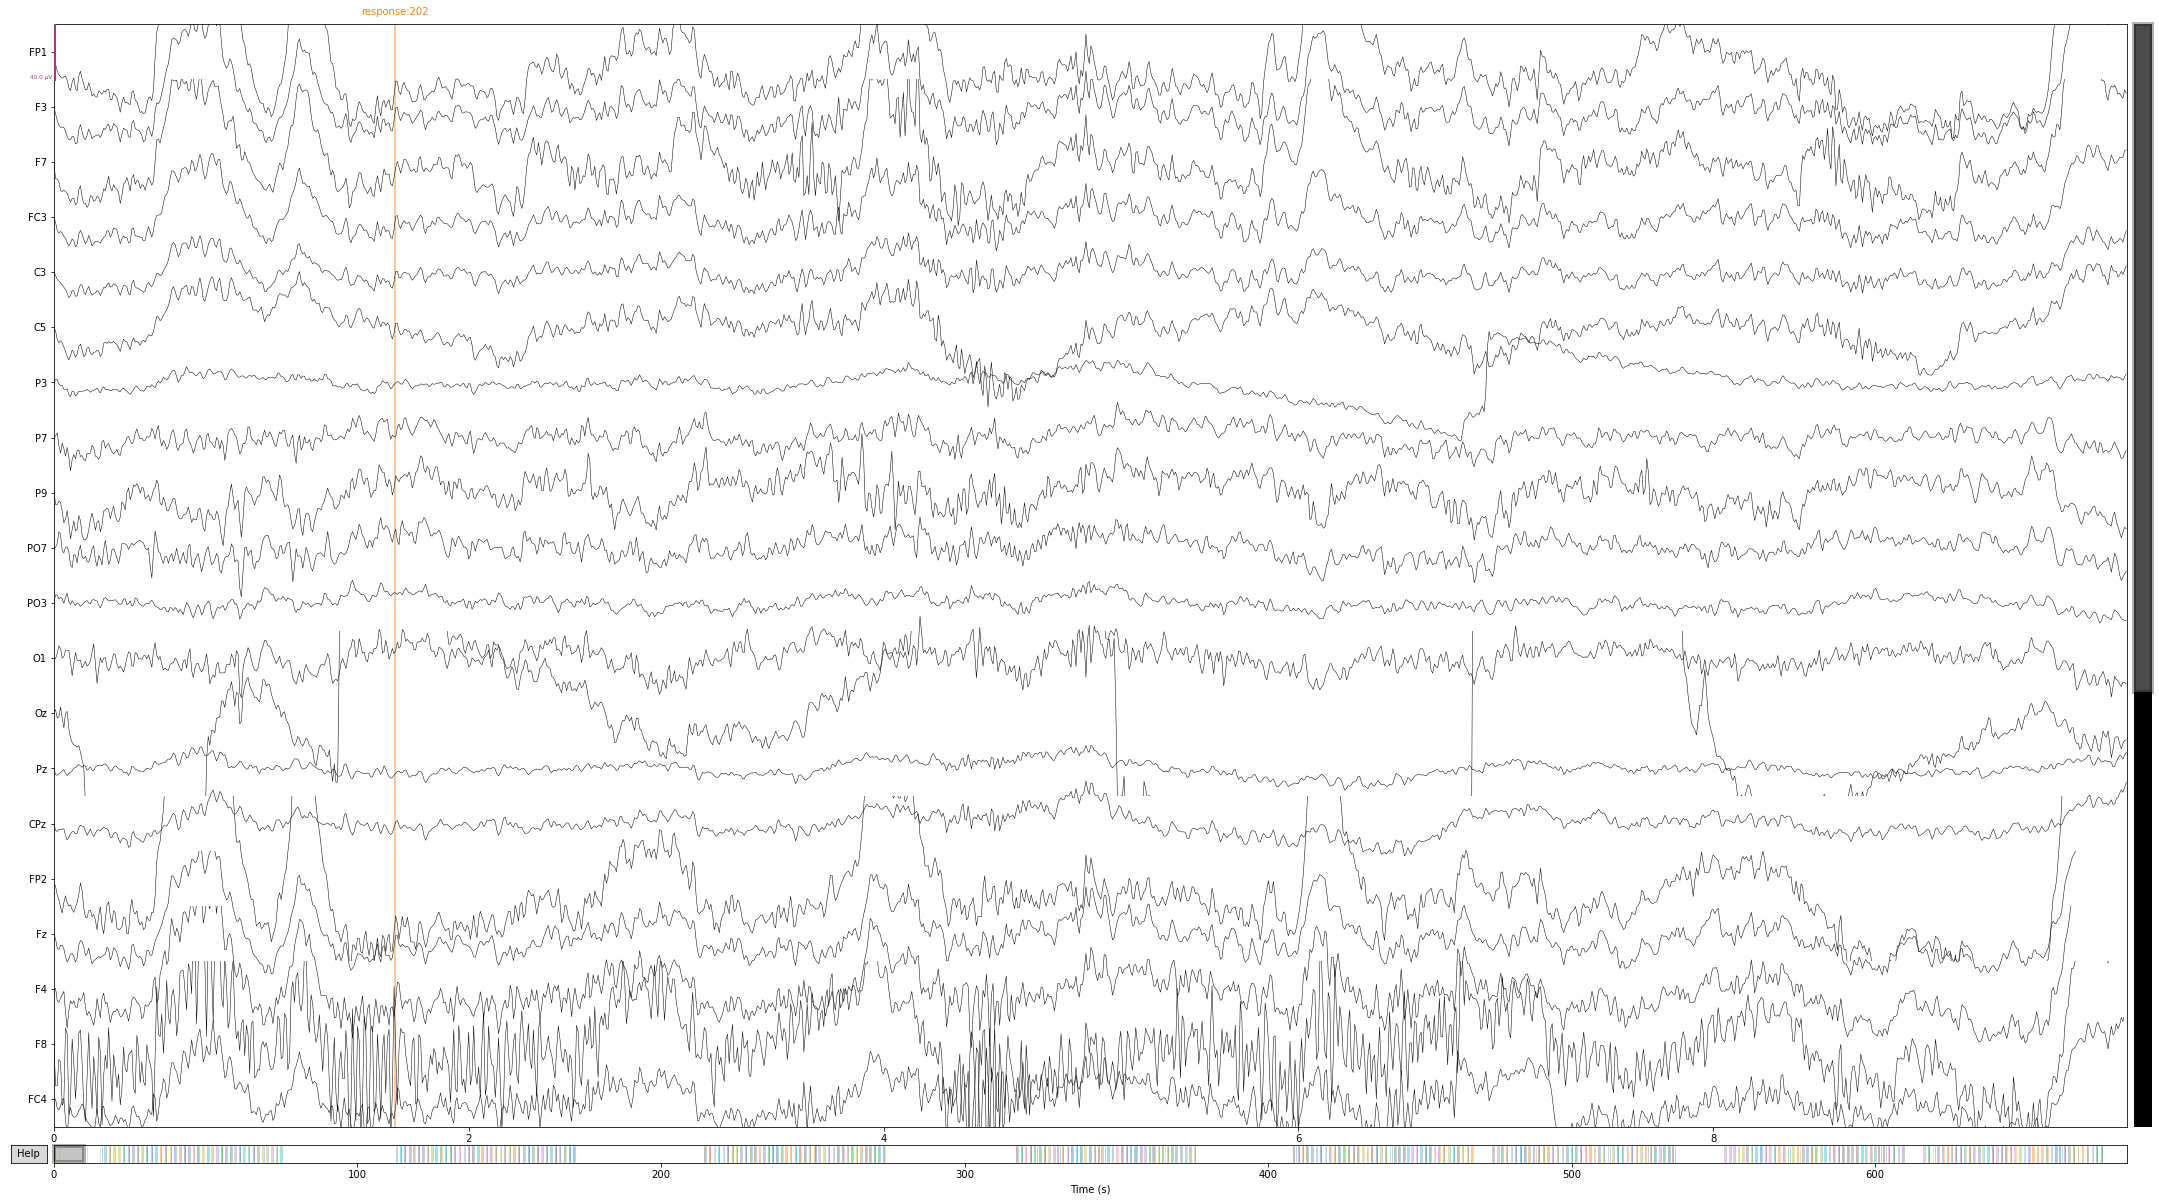

In [2]:
data_path = "F:/Masterthesis/Data/"
task = "N170"
preprocessing = "medium"
raw = load_raw(data_path, task, preprocessing, "001")
raw.plot();

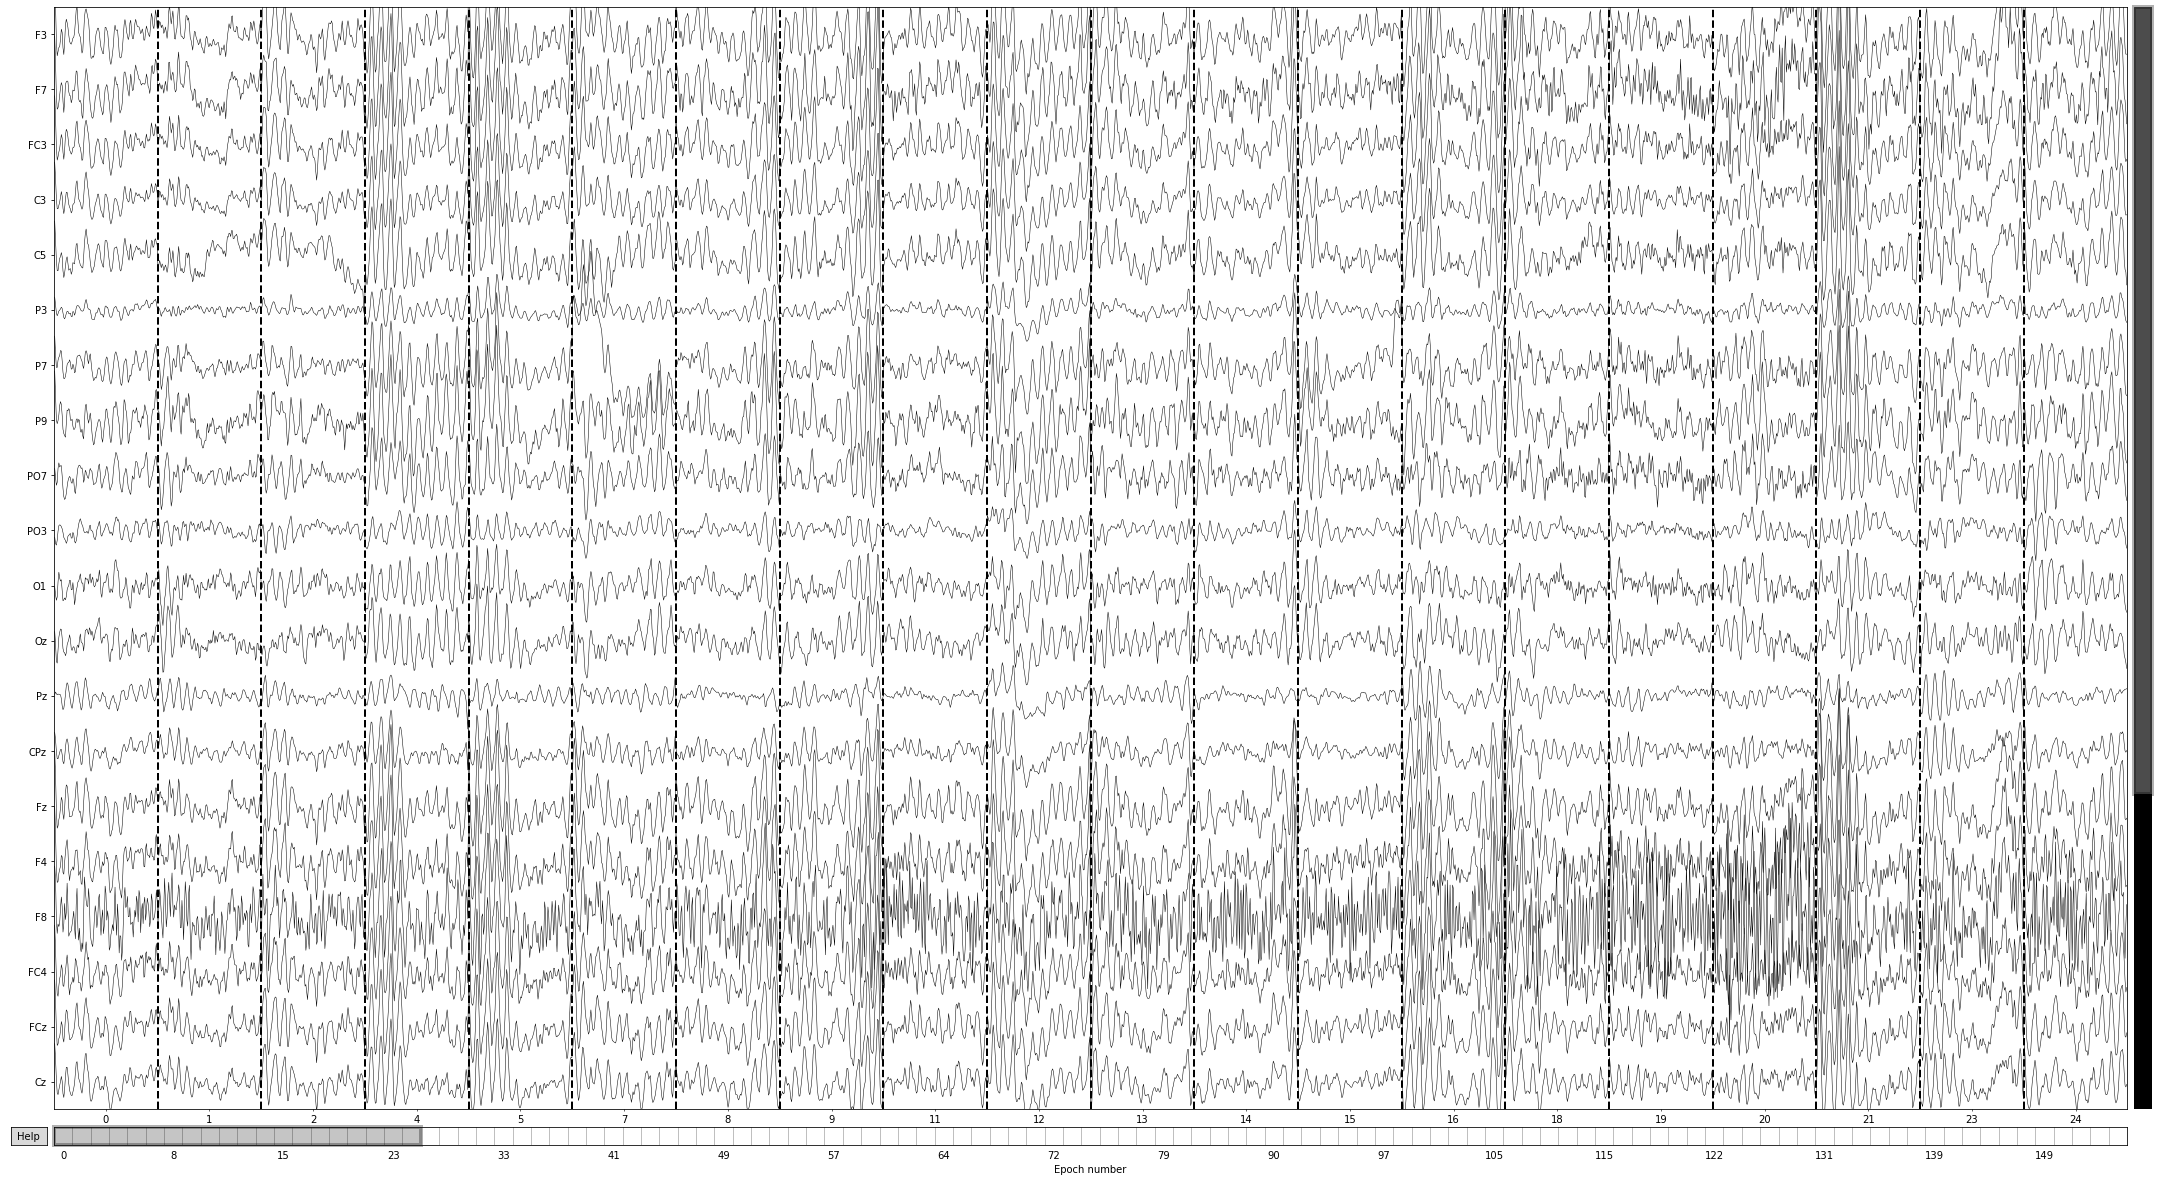

In [3]:
epoch = epoch_raw(raw, task, preprocessing)
epoch.plot();

In [4]:
df = create_df(data_path, task, preprocessing)
df

,epoch,condition,subjectID,data
0,0,0,0,"[[41.23027354522549, 41.76507820944795, 38.928..."
1,1,0,0,"[[1.9524139500691624, 3.7566056980455445, 4.69..."
2,2,0,0,"[[-3.0399094019800486, 2.3797442472317196, 9.6..."
3,4,1,0,"[[-4.60570607906713, -9.745721803170467, -15.1..."
4,5,1,0,"[[42.81865940169189, 36.85808844487722, 27.594..."
...,...,...,...,...
5776,154,1,39,"[[-3.7487470514909713, -8.081862739628036, -9...."
5777,155,0,39,"[[-15.285657236963576, -18.274890462977787, -1..."
5778,156,1,39,"[[35.73841564706618, 28.06711892997384, 20.267..."
5779,157,0,39,"[[-25.679635212812062, -25.217531937162754, -2..."


## Create and save Dataframes

In [5]:
data_path = "F:/Masterthesis/Data/"
for task in ["N170", "N400", "P3", "MMN", "N2pc", "ERN", "LRP"]:
    for preprocessing in ["medium"]:
        df = create_df(data_path, task, preprocessing)
        save_df(df)

In [2]:
data_path = "F:/Masterthesis/Data/"
for task in ["N170", "N400", "P3"]:
    for preprocessing in ["heavy"]:
        df = create_df(data_path, task, preprocessing)
        save_df(df)

Computing thresholds ...: 100%|████████████████████████████████████████████████████████| 28/28 [00:09<00:00,  2.82it/s]


Repairing epochs:   0%|                                                                        | 0/113 [00:00<?, ?it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 678.46it/s]

n_interp:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|                                                                        | 0/113 [00:00<?, ?it/s]

Repairing epochs:  17%|██████████▍                                                   | 19/113 [00:00<00:00, 179.73it/s]

Repairing epochs:  35%|█████████████████████▉                                        | 40/113 [00:00<00:00, 195.16it/s]

Repairing epochs:  53%|████████████████████████████████▉                             | 60/113 [00:00<00:00, 189.92it/s]

Repairing epochs:  71%|████████

Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:00, 12.46it/s]


Fold:  40%|██████████████████████████████▊                                              | 4/10 [00:00<00:00, 12.55it/s]


Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:00<00:00, 12.69it/s]


Fold:  80%|█████████████████████████████████████████████████████████████▌               | 8/10 [00:00<00:00, 12.63it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.63it/s]

n_interp:  67%|█████████████████████████████████████████████████▎                        | 2/3 [00:02<00:01,  1.40s/it]

Repairing epochs:   0%|                                                                        | 0/153 [00:00<?, ?it/s]

Repairing epochs:  23%|██████████████▏                                               | 35/153 [00:00<00:00, 334.14it/s]

Repairing epochs:  45%|█████

Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.53it/s]

n_interp:  33%|████████████████████████▋                                                 | 1/3 [00:01<00:02,  1.37s/it]

Repairing epochs:   0%|                                                                        | 0/127 [00:00<?, ?it/s]

Repairing epochs:  16%|█████████▊                                                    | 20/127 [00:00<00:00, 198.55it/s]

Repairing epochs:  31%|███████████████████▌                                          | 40/127 [00:00<00:00, 192.93it/s]

Repairing epochs:  49%|██████████████████████████████▎                               | 62/127 [00:00<00:00, 203.47it/s]

Repairing epochs:  65%|████████████████████████████████████████▌                     | 83/127 [00:00<00:00, 204.64it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 213.66it/s]



Fold:   0%|                   

Repairing epochs:  26%|████████████████                                              | 38/147 [00:00<00:00, 177.44it/s]

Repairing epochs:  39%|████████████████████████                                      | 57/147 [00:00<00:00, 180.79it/s]

Repairing epochs:  52%|████████████████████████████████                              | 76/147 [00:00<00:00, 181.73it/s]

Repairing epochs:  65%|████████████████████████████████████████                      | 95/147 [00:00<00:00, 184.16it/s]

Repairing epochs:  78%|███████████████████████████████████████████████▎             | 114/147 [00:00<00:00, 183.84it/s]

Computing thresholds ...: 100%|████████████████████████████████████████████████████████| 28/28 [00:10<00:00,  2.56it/s]


Repairing epochs:   0%|                                                                        | 0/155 [00:00<?, ?it/s]

Repairing epochs:  47%|█████████████████████████████▏                                | 73/155 [00:00<00:00, 717.60it/s]

Repairing epochs: 100%|████████

Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60it/s]

n_interp:  33%|████████████████████████▋                                                 | 1/3 [00:01<00:03,  1.70s/it]

Repairing epochs:   0%|                                                                        | 0/147 [00:00<?, ?it/s]

Repairing epochs:  14%|████████▊                                                     | 21/147 [00:00<00:00, 200.15it/s]

Repairing epochs:  29%|█████████████████▋                                            | 42/147 [00:00<00:00, 186.78it/s]

Repairing epochs:  43%|██████████████████████████▌                                   | 63/147 [00:00<00:00, 195.27it/s]

Repairing epochs:  56%|███████████████████████████████████                           | 83/147 [00:00<00:00, 195.80it/s]

Repairing epochs:  70%|██████████████████████████████████████████▋                  | 103/147 [00:00<00:00, 192.75it/s]

Repairing epochs:  84%|█████████

Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:00<00:00, 12.75it/s]


Fold:  80%|█████████████████████████████████████████████████████████████▌               | 8/10 [00:00<00:00, 12.66it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.66it/s]

n_interp:  67%|█████████████████████████████████████████████████▎                        | 2/3 [00:03<00:01,  1.70s/it]

Repairing epochs:   0%|                                                                        | 0/149 [00:00<?, ?it/s]

Repairing epochs:  13%|████████▎                                                     | 20/149 [00:00<00:00, 190.99it/s]

Repairing epochs:  27%|████████████████▋                                             | 40/149 [00:00<00:00, 185.78it/s]

Repairing epochs:  40%|████████████████████████▌                                     | 59/149 [00:00<00:00, 181.50it/s]

Repairing epochs:  53%|███████

Repairing epochs:   0%|                                                                         | 0/79 [00:00<?, ?it/s]

Repairing epochs: 100%|███████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 720.10it/s]

n_interp:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|                                                                         | 0/79 [00:00<?, ?it/s]

Repairing epochs:  32%|███████████████████▉                                           | 25/79 [00:00<00:00, 238.73it/s]

Repairing epochs:  62%|███████████████████████████████████████                        | 49/79 [00:00<00:00, 228.01it/s]

Repairing epochs: 100%|███████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 219.94it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  30%|██████████████████

Repairing epochs:  16%|█████████▊                                                    | 22/139 [00:00<00:00, 214.11it/s]

Repairing epochs:  32%|████████████████████                                          | 45/139 [00:00<00:00, 219.87it/s]

Repairing epochs:  48%|█████████████████████████████▉                                | 67/139 [00:00<00:00, 209.84it/s]

Repairing epochs:  65%|████████████████████████████████████████▏                     | 90/139 [00:00<00:00, 215.28it/s]

Computing thresholds ...: 100%|████████████████████████████████████████████████████████| 28/28 [00:12<00:00,  2.32it/s]


Repairing epochs:   0%|                                                                        | 0/157 [00:00<?, ?it/s]

Repairing epochs:  46%|████████████████████████████▊                                 | 73/157 [00:00<00:00, 724.70it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 690.44it/s]

n_interp:   0%|                

Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.83it/s]

n_interp:  33%|████████████████████████▋                                                 | 1/3 [00:01<00:03,  1.74s/it]

Repairing epochs:   0%|                                                                        | 0/154 [00:00<?, ?it/s]

Repairing epochs:  14%|████████▍                                                     | 21/154 [00:00<00:00, 198.69it/s]

Repairing epochs:  27%|████████████████▌                                             | 41/154 [00:00<00:00, 192.37it/s]

Repairing epochs:  40%|████████████████████████▌                                     | 61/154 [00:00<00:00, 192.57it/s]

Repairing epochs:  53%|████████████████████████████████▌                             | 81/154 [00:00<00:00, 191.25it/s]

Repairing epochs:  66%|████████████████████████████████████████                     | 101/154 [00:00<00:00, 190.48it/s]

Repairing epochs:  79%|█████████

Repairing epochs:   0%|                                                                        | 0/140 [00:00<?, ?it/s]

Repairing epochs:  16%|█████████▋                                                    | 22/140 [00:00<00:00, 218.35it/s]

Repairing epochs:  31%|███████████████████▍                                          | 44/140 [00:00<00:00, 215.87it/s]

Repairing epochs:  47%|█████████████████████████████▏                                | 66/140 [00:00<00:00, 212.25it/s]

Repairing epochs:  64%|███████████████████████████████████████▍                      | 89/140 [00:00<00:00, 215.18it/s]

Repairing epochs:  81%|█████████████████████████████████████████████████▏           | 113/140 [00:00<00:00, 220.27it/s]

Computing thresholds ...: 100%|████████████████████████████████████████████████████████| 28/28 [00:10<00:00,  2.58it/s]


Repairing epochs:   0%|                                                                        | 0/147 [00:00<?, ?it/s]

Repairing epochs:  50%|████████

Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.39it/s]

n_interp:  67%|█████████████████████████████████████████████████▎                        | 2/3 [00:03<00:01,  1.50s/it]

Repairing epochs:   0%|                                                                        | 0/156 [00:00<?, ?it/s]

Repairing epochs:  27%|████████████████▋                                             | 42/156 [00:00<00:00, 397.28it/s]

Repairing epochs:  53%|████████████████████████████████▌                             | 82/156 [00:00<00:00, 306.24it/s]

Repairing epochs:  73%|████████████████████████████████████████████▌                | 114/156 [00:00<00:00, 267.48it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 261.56it/s]



Fold: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 101.24it/s]

n_interp: 100%|███████████████

Repairing epochs:  71%|████████████████████████████████████████████▏                 | 99/139 [00:00<00:00, 185.19it/s]

Repairing epochs:  85%|███████████████████████████████████████████████████▊         | 118/139 [00:00<00:00, 185.72it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 186.82it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:00, 12.30it/s]


Fold:  40%|██████████████████████████████▊                                              | 4/10 [00:00<00:00, 12.26it/s]


Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:00<00:00, 12.49it/s]


Fold:  80%|█████████████████████████████████████████████████████████████▌               | 8/10 [00:00<00:00, 12.76it/s]


Fold: 100%|██████████████

Repairing epochs:   0%|                                                                        | 0/154 [00:00<?, ?it/s]

Repairing epochs:  45%|████████████████████████████▏                                 | 70/154 [00:00<00:00, 694.93it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 154/154 [00:00<00:00, 683.16it/s]

n_interp:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|                                                                        | 0/154 [00:00<?, ?it/s]

Repairing epochs:  16%|██████████                                                    | 25/154 [00:00<00:00, 247.88it/s]

Repairing epochs:  33%|████████████████████▌                                         | 51/154 [00:00<00:00, 248.12it/s]

Repairing epochs:  52%|████████████████████████████████▏                             | 80/154 [00:00<00:00, 266.05it/s]

Repairing epochs:  69%|█████████

Repairing epochs:  36%|██████████████████████▌                                       | 53/146 [00:00<00:00, 256.44it/s]

Repairing epochs:  54%|█████████████████████████████████▌                            | 79/146 [00:00<00:00, 253.99it/s]

Repairing epochs:  72%|███████████████████████████████████████████▊                 | 105/146 [00:00<00:00, 250.77it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 260.08it/s]



Fold: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 113.91it/s]

n_interp: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


Repairing epochs:   0%|                                                                        | 0/146 [00:00<?, ?it/s]

Repairing epochs:  17%|██████████▌                                                   | 25/146 [00:00<00:00, 241.05it/s]

Repairing epochs:  35%|██████

Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:00, 12.38it/s]


Fold:  40%|██████████████████████████████▊                                              | 4/10 [00:00<00:00, 12.42it/s]


Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:00<00:00, 12.58it/s]


Fold:  80%|█████████████████████████████████████████████████████████████▌               | 8/10 [00:00<00:00, 12.44it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.47it/s]

n_interp:  67%|█████████████████████████████████████████████████▎                        | 2/3 [00:02<00:01,  1.45s/it]

Repairing epochs:   0%|                                                                        | 0/146 [00:00<?, ?it/s]

Repairing epochs:  20%|████

Repairing epochs:  49%|██████████████████████████████▏                               | 69/142 [00:00<00:00, 220.47it/s]

Repairing epochs:  65%|████████████████████████████████████████▏                     | 92/142 [00:00<00:00, 213.73it/s]

Repairing epochs:  80%|████████████████████████████████████████████████▉            | 114/142 [00:00<00:00, 212.45it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 209.07it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:00, 12.23it/s]


Fold:  40%|██████████████████████████████▊                                              | 4/10 [00:00<00:00, 12.01it/s]


Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:00<00:00, 12.13it/s]


Fold:  80%|███████████████

Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:00, 17.14it/s]


Fold:  40%|██████████████████████████████▊                                              | 4/10 [00:00<00:00, 16.85it/s]


Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:00<00:00, 16.35it/s]


Fold:  80%|█████████████████████████████████████████████████████████████▌               | 8/10 [00:00<00:00, 16.38it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.45it/s]

n_interp:  67%|█████████████████████████████████████████████████▎                        | 2/3 [00:02<00:01,  1.10s/it]

Repairing epochs:   0%|                                                                        | 0/112 [00:00<?, ?it/s]

Repairing epochs:  26%|████████████████                                              | 29/112 [00:00<00:00, 271.75it/s]

Repairing epochs:  51%|█████

Repairing epochs:   0%|                                                                        | 0/102 [00:00<?, ?it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 955.82it/s]

n_interp:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|                                                                        | 0/102 [00:00<?, ?it/s]

Repairing epochs:  26%|████████████████▍                                             | 27/102 [00:00<00:00, 265.36it/s]

Repairing epochs:  53%|████████████████████████████████▊                             | 54/102 [00:00<00:00, 239.18it/s]

Repairing epochs:  77%|████████████████████████████████████████████████              | 79/102 [00:00<00:00, 214.74it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 216.18it/s]



Fold:   0%|                   

n_interp:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|                                                                         | 0/94 [00:00<?, ?it/s]

Repairing epochs:  20%|████████████▋                                                  | 19/94 [00:00<00:00, 181.38it/s]

Repairing epochs:  40%|█████████████████████████▍                                     | 38/94 [00:00<00:00, 183.42it/s]

Repairing epochs:  61%|██████████████████████████████████████▏                        | 57/94 [00:00<00:00, 184.12it/s]

Repairing epochs: 100%|███████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 182.28it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:00, 19.28it/s]


Fold:  40%|█████████████████

Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  30%|███████████████████████                                                      | 3/10 [00:00<00:00, 24.45it/s]


Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:00<00:00, 24.22it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 24.22it/s]

n_interp:  33%|████████████████████████▋                                                 | 1/3 [00:00<00:01,  1.23it/s]

Repairing epochs:   0%|                                                                         | 0/68 [00:00<?, ?it/s]

Repairing epochs:  31%|███████████████████▍                                           | 21/68 [00:00<00:00, 200.49it/s]

Repairing epochs:  62%|██████████████████████████████████████▉                        | 42/68 [00:00<00:00, 201.65it/s]

Repairing epochs: 100%|██████

Repairing epochs:   0%|                                                                         | 0/74 [00:00<?, ?it/s]

Repairing epochs:  26%|████████████████▏                                              | 19/74 [00:00<00:00, 184.96it/s]

Repairing epochs:  51%|████████████████████████████████▎                              | 38/74 [00:00<00:00, 184.96it/s]

Repairing epochs: 100%|███████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 193.21it/s]



Fold: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 222.77it/s]

n_interp: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.45it/s]


Repairing epochs:   0%|                                                                         | 0/74 [00:00<?, ?it/s]

Repairing epochs:  26%|████████████████▏                                              | 19/74 [00:00<00:00, 188.57it/s]

Repairing epochs:  53%|██████

Repairing epochs: 100%|███████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 968.88it/s]

n_interp:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|                                                                         | 0/86 [00:00<?, ?it/s]

Repairing epochs:  22%|█████████████▉                                                 | 19/86 [00:00<00:00, 184.91it/s]

Repairing epochs:  44%|███████████████████████████▊                                   | 38/86 [00:00<00:00, 186.01it/s]

Repairing epochs:  66%|█████████████████████████████████████████▊                     | 57/86 [00:00<00:00, 185.53it/s]

Repairing epochs: 100%|███████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 185.84it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  30%|██████████████████

Repairing epochs:  25%|███████████████▌                                               | 22/89 [00:00<00:00, 218.40it/s]

Repairing epochs:  49%|███████████████████████████████▏                               | 44/89 [00:00<00:00, 209.82it/s]

Repairing epochs:  74%|██████████████████████████████████████████████▋                | 66/89 [00:00<00:00, 207.24it/s]

Computing thresholds ...: 100%|████████████████████████████████████████████████████████| 28/28 [00:08<00:00,  3.47it/s]


Repairing epochs: 100%|███████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 972.74it/s]

n_interp:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|                                                                         | 0/65 [00:00<?, ?it/s]

Repairing epochs:  42%|██████████████████████████▏                                    | 27/65 [00:00<00:00, 257.83it/s]

Repairing epochs: 100%|████████

n_interp:  67%|█████████████████████████████████████████████████▎                        | 2/3 [00:01<00:00,  1.73it/s]

Repairing epochs:   0%|                                                                         | 0/57 [00:00<?, ?it/s]

Repairing epochs:  40%|█████████████████████████▍                                     | 23/57 [00:00<00:00, 228.39it/s]

Repairing epochs: 100%|███████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 222.39it/s]



Fold: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 286.27it/s]

n_interp: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


Repairing epochs:   0%|                                                                         | 0/57 [00:00<?, ?it/s]

Repairing epochs:  42%|██████████████████████████▌                                    | 24/57 [00:00<00:00, 238.20it/s]

Computing thresholds ...: 100

Computing thresholds ...: 100%|████████████████████████████████████████████████████████| 28/28 [00:09<00:00,  3.09it/s]


Repairing epochs: 100%|███████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 948.77it/s]

n_interp:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|                                                                         | 0/88 [00:00<?, ?it/s]

Repairing epochs:  23%|██████████████▎                                                | 20/88 [00:00<00:00, 194.64it/s]

Repairing epochs:  47%|█████████████████████████████▎                                 | 41/88 [00:00<00:00, 202.72it/s]

Repairing epochs:  70%|████████████████████████████████████████████▍                  | 62/88 [00:00<00:00, 198.20it/s]

Repairing epochs: 100%|███████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 198.72it/s]



Fold:   0%|                  

n_interp: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]


Repairing epochs:   0%|                                                                         | 0/95 [00:00<?, ?it/s]

Repairing epochs:  25%|███████████████▉                                               | 24/95 [00:00<00:00, 229.21it/s]

Repairing epochs:  49%|███████████████████████████████▏                               | 47/95 [00:00<00:00, 217.45it/s]

Repairing epochs:  73%|█████████████████████████████████████████████▊                 | 69/95 [00:00<00:00, 211.42it/s]

Computing thresholds ...: 100%|████████████████████████████████████████████████████████| 28/28 [00:08<00:00,  3.27it/s]


Repairing epochs: 100%|███████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 965.99it/s]

n_interp:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|       

Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:00<00:00, 28.99it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.15it/s]

n_interp:  67%|█████████████████████████████████████████████████▎                        | 2/3 [00:01<00:00,  1.44it/s]

Repairing epochs:   0%|                                                                         | 0/63 [00:00<?, ?it/s]

Repairing epochs:  30%|███████████████████                                            | 19/63 [00:00<00:00, 181.39it/s]

Repairing epochs:  60%|██████████████████████████████████████                         | 38/63 [00:00<00:00, 174.60it/s]

Repairing epochs: 100%|███████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 176.44it/s]



Fold: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 263.69it/s]

n_interp: 100%|██████████████

Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]

n_interp:  33%|████████████████████████▋                                                 | 1/3 [00:02<00:04,  2.00s/it]

Repairing epochs:   0%|                                                                        | 0/198 [00:00<?, ?it/s]

Repairing epochs:  13%|███████▊                                                      | 25/198 [00:00<00:00, 245.76it/s]

Repairing epochs:  25%|███████████████▋                                              | 50/198 [00:00<00:00, 242.95it/s]

Repairing epochs:  38%|███████████████████████▍                                      | 75/198 [00:00<00:00, 236.85it/s]

Repairing epochs:  51%|██████████████████████████████▊                              | 100/198 [00:00<00:00, 240.29it/s]

Repairing epochs:  64%|██████████████████████████████████████▊                      | 126/198 [00:00<00:00, 245.05it/s]

Repairing epochs:  77%|█████████

n_interp:  67%|█████████████████████████████████████████████████▎                        | 2/3 [00:03<00:01,  1.65s/it]

Repairing epochs:   0%|                                                                        | 0/190 [00:00<?, ?it/s]

Repairing epochs:  15%|█████████▏                                                    | 28/190 [00:00<00:00, 267.31it/s]

Repairing epochs:  31%|██████████████████▉                                           | 58/190 [00:00<00:00, 283.35it/s]

Repairing epochs:  47%|█████████████████████████████                                 | 89/190 [00:00<00:00, 293.08it/s]

Repairing epochs:  67%|████████████████████████████████████████▊                    | 127/190 [00:00<00:00, 319.79it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 325.10it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold: 100%|██████████████████

n_interp:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|                                                                        | 0/194 [00:00<?, ?it/s]

Repairing epochs:  18%|██████████▊                                                   | 34/194 [00:00<00:00, 327.80it/s]

Repairing epochs:  35%|█████████████████████▍                                        | 67/194 [00:00<00:00, 265.10it/s]

Repairing epochs:  49%|██████████████████████████████▎                               | 95/194 [00:00<00:00, 244.94it/s]

Repairing epochs:  63%|██████████████████████████████████████▎                      | 122/194 [00:00<00:00, 250.30it/s]

Repairing epochs:  76%|██████████████████████████████████████████████▌              | 148/194 [00:00<00:00, 237.51it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 243.15it/s]



Fold:   0%|                   

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 195.46it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:00, 11.59it/s]


Fold:  40%|██████████████████████████████▊                                              | 4/10 [00:00<00:00, 11.57it/s]


Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:00<00:00, 11.61it/s]


Fold:  80%|█████████████████████████████████████████████████████████████▌               | 8/10 [00:00<00:00, 11.68it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.65it/s]

n_interp:  67%|█████████████████████████████████████████████████▎                        | 2/3 [00:03<00:01,  1.88s/it]

Repairing epochs:   0%|  

Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.57it/s]

n_interp:  67%|█████████████████████████████████████████████████▎                        | 2/3 [00:04<00:02,  2.15s/it]

Repairing epochs:   0%|                                                                        | 0/199 [00:00<?, ?it/s]

Repairing epochs:  11%|██████▌                                                       | 21/199 [00:00<00:00, 209.70it/s]

Repairing epochs:  21%|█████████████                                                 | 42/199 [00:00<00:00, 200.77it/s]

Repairing epochs:  32%|███████████████████▋                                          | 63/199 [00:00<00:00, 200.66it/s]

Repairing epochs:  42%|██████████████████████████▏                                   | 84/199 [00:00<00:00, 190.58it/s]

Repairing epochs:  52%|███████████████████████████████▉                             | 104/199 [00:00<00:00, 190.72it/s]

Repairing epochs:  62%|█████████

Repairing epochs:  59%|████████████████████████████████████                         | 111/188 [00:00<00:00, 208.32it/s]

Repairing epochs:  70%|██████████████████████████████████████████▊                  | 132/188 [00:00<00:00, 205.69it/s]

Repairing epochs:  84%|██████████████████████████████████████████████████▉          | 157/188 [00:00<00:00, 218.46it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 214.45it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:00, 10.50it/s]


Fold:  40%|██████████████████████████████▊                                              | 4/10 [00:00<00:00, 10.22it/s]


Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:00<00:00, 10.32it/s]


Fold:  80%|███████████████

Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  10%|███████▋                                                                     | 1/10 [00:00<00:00,  9.46it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:00,  9.30it/s]


Fold:  30%|███████████████████████                                                      | 3/10 [00:00<00:00,  9.22it/s]


Fold:  40%|██████████████████████████████▊                                              | 4/10 [00:00<00:00,  9.28it/s]


Fold:  50%|██████████████████████████████████████▌                                      | 5/10 [00:00<00:00,  9.31it/s]


Fold:  60%|██████████████████████████████████████████████▏                              | 6/10 [00:00<00:00,  9.19it/s]


Fold:  70%|█████████████████████████████████████████████████████▉                       | 7/10 [00:00<00:00,  9.25it/s]


Fold:  80%|█████████████

Repairing epochs:  42%|█████████████████████████▊                                    | 80/192 [00:00<00:00, 189.56it/s]

Repairing epochs:  52%|███████████████████████████████▉                              | 99/192 [00:00<00:00, 187.75it/s]

Repairing epochs:  61%|█████████████████████████████████████▍                       | 118/192 [00:00<00:00, 171.70it/s]

Repairing epochs:  71%|███████████████████████████████████████████▌                 | 137/192 [00:00<00:00, 176.81it/s]

Repairing epochs:  81%|█████████████████████████████████████████████████▌           | 156/192 [00:00<00:00, 180.36it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 192/192 [00:01<00:00, 184.82it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:00, 10.28it/s]


Fold:  40%|█████████████████

Fold:  90%|█████████████████████████████████████████████████████████████████████▎       | 9/10 [00:01<00:00,  8.90it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.95it/s]

n_interp:  33%|████████████████████████▋                                                 | 1/3 [00:02<00:04,  2.13s/it]

Repairing epochs:   0%|                                                                        | 0/198 [00:00<?, ?it/s]

Repairing epochs:  11%|██████▌                                                       | 21/198 [00:00<00:00, 204.38it/s]

Repairing epochs:  22%|█████████████▍                                                | 43/198 [00:00<00:00, 206.59it/s]

Repairing epochs:  33%|████████████████████▎                                         | 65/198 [00:00<00:00, 211.88it/s]

Repairing epochs:  45%|███████████████████████████▊                                  | 89/198 [00:00<00:00, 222.16it/s]

Repairing epochs:  57%|████████

n_interp:  33%|████████████████████████▋                                                 | 1/3 [00:01<00:03,  1.94s/it]

Repairing epochs:   0%|                                                                        | 0/193 [00:00<?, ?it/s]

Repairing epochs:  13%|████████                                                      | 25/193 [00:00<00:00, 240.98it/s]

Repairing epochs:  26%|████████████████                                              | 50/193 [00:00<00:00, 215.42it/s]

Repairing epochs:  38%|███████████████████████▊                                      | 74/193 [00:00<00:00, 221.01it/s]

Repairing epochs:  50%|███████████████████████████████▏                              | 97/193 [00:00<00:00, 213.98it/s]

Repairing epochs:  64%|██████████████████████████████████████▉                      | 123/193 [00:00<00:00, 227.31it/s]

Repairing epochs:  76%|██████████████████████████████████████████████▏              | 146/193 [00:00<00:00, 216.55it/s]

Repairing epochs: 100%|█████████

Fold:  90%|█████████████████████████████████████████████████████████████████████▎       | 9/10 [00:00<00:00,  9.63it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.69it/s]

n_interp:  67%|█████████████████████████████████████████████████▎                        | 2/3 [00:03<00:01,  1.82s/it]

Repairing epochs:   0%|                                                                        | 0/193 [00:00<?, ?it/s]

Repairing epochs:  14%|████████▋                                                     | 27/193 [00:00<00:00, 257.83it/s]

Repairing epochs:  27%|█████████████████                                             | 53/193 [00:00<00:00, 256.52it/s]

Repairing epochs:  42%|██████████████████████████                                    | 81/193 [00:00<00:00, 262.68it/s]

Repairing epochs:  56%|██████████████████████████████████▏                          | 108/193 [00:00<00:00, 259.70it/s]

Repairing epochs:  69%|████████

Repairing epochs:  69%|█████████████████████████████████████████▉                   | 132/192 [00:00<00:00, 254.07it/s]

Repairing epochs:  83%|██████████████████████████████████████████████████▌          | 159/192 [00:00<00:00, 244.09it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 251.64it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 88.73it/s]

n_interp: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.53s/it]


Repairing epochs:   0%|                                                                        | 0/192 [00:00<?, ?it/s]

Repairing epochs:  19%|███████████▋                                                  | 36/192 [00:00<00:00, 347.08it/s]

Repairing epochs:  37%|█████

Fold: 100%|████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 84.26it/s]

n_interp: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.62s/it]


Repairing epochs:   0%|                                                                        | 0/198 [00:00<?, ?it/s]

Repairing epochs:  13%|████████▏                                                     | 26/198 [00:00<00:00, 245.88it/s]

Repairing epochs:  26%|███████████████▉                                              | 51/198 [00:00<00:00, 228.95it/s]

Repairing epochs:  37%|███████████████████████▏                                      | 74/198 [00:00<00:00, 222.00it/s]

Repairing epochs:  51%|███████████████████████████████                              | 101/198 [00:00<00:00, 235.79it/s]

Repairing epochs:  63%|██████████████████████████████████████▌                      | 125/198 [00:00<00:00, 233.43it/s]

Repairing epochs:  77%|████████

Repairing epochs:  34%|█████████████████████▎                                        | 63/183 [00:00<00:00, 199.13it/s]

Repairing epochs:  46%|████████████████████████████▍                                 | 84/183 [00:00<00:00, 202.72it/s]

Repairing epochs:  57%|███████████████████████████████████                          | 105/183 [00:00<00:00, 198.28it/s]

Repairing epochs:  69%|██████████████████████████████████████████                   | 126/183 [00:00<00:00, 198.42it/s]

Repairing epochs:  80%|████████████████████████████████████████████████▋            | 146/183 [00:00<00:00, 196.01it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 204.77it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  10%|███████▋                                                                     | 1/10 [00:00<00:00,  9.93it/s]


Fold:  20%|███████████████▍ 

Repairing epochs:  65%|███████████████████████████████████████▍                     | 128/198 [00:00<00:00, 177.75it/s]

Repairing epochs:  74%|████████████████████████████████████████████▉                | 146/198 [00:00<00:00, 177.50it/s]

Repairing epochs:  83%|██████████████████████████████████████████████████▌          | 164/198 [00:00<00:00, 177.34it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 198/198 [00:01<00:00, 177.42it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  10%|███████▋                                                                     | 1/10 [00:00<00:00,  9.12it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:00,  9.21it/s]


Fold:  30%|███████████████████████                                                      | 3/10 [00:00<00:00,  9.29it/s]


Fold:  40%|███████████████

Repairing epochs:  64%|██████████████████████████████████████▊                      | 126/198 [00:00<00:00, 246.10it/s]

Repairing epochs:  76%|██████████████████████████████████████████████▌              | 151/198 [00:00<00:00, 240.51it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 240.35it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  10%|███████▋                                                                     | 1/10 [00:00<00:01,  8.95it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:00,  8.95it/s]


Fold:  30%|███████████████████████                                                      | 3/10 [00:00<00:00,  8.92it/s]


Fold:  40%|██████████████████████████████▊                                              | 4/10 [00:00<00:00,  8.93it/s]


Fold:  50%|██████████████

Repairing epochs:  49%|██████████████████████████████▎                               | 85/174 [00:00<00:00, 843.83it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 855.22it/s]

n_interp:   0%|                                                                                  | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|                                                                        | 0/174 [00:00<?, ?it/s]

Repairing epochs:  11%|███████▏                                                      | 20/174 [00:00<00:00, 190.95it/s]

Repairing epochs:  23%|██████████████▎                                               | 40/174 [00:00<00:00, 192.05it/s]

Repairing epochs:  34%|█████████████████████▍                                        | 60/174 [00:00<00:00, 188.27it/s]

Repairing epochs:  45%|████████████████████████████▏                                 | 79/174 [00:00<00:00, 182.87it/s]

Repairing epochs:  56%|█████████

Repairing epochs:  58%|███████████████████████████████████▍                         | 112/193 [00:00<00:00, 233.15it/s]

Repairing epochs:  71%|███████████████████████████████████████████▎                 | 137/193 [00:00<00:00, 238.05it/s]

Repairing epochs:  83%|██████████████████████████████████████████████████▉          | 161/193 [00:00<00:00, 235.91it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 234.87it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  10%|███████▋                                                                     | 1/10 [00:00<00:01,  8.87it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:00,  8.97it/s]


Fold:  30%|███████████████████████                                                      | 3/10 [00:00<00:00,  9.07it/s]


Fold:  40%|███████████████

Repairing epochs:  53%|████████████████████████████████▎                            | 104/196 [00:00<00:00, 245.69it/s]

Repairing epochs:  66%|████████████████████████████████████████▏                    | 129/196 [00:00<00:00, 235.18it/s]

Repairing epochs:  79%|████████████████████████████████████████████████▏            | 155/196 [00:00<00:00, 239.51it/s]

Repairing epochs: 100%|█████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 235.36it/s]



Fold:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]


Fold:  10%|███████▋                                                                     | 1/10 [00:00<00:01,  8.72it/s]


Fold:  20%|███████████████▍                                                             | 2/10 [00:00<00:00,  8.90it/s]


Fold:  30%|███████████████████████                                                      | 3/10 [00:00<00:00,  8.92it/s]


Fold:  40%|███████████████